In [47]:
import re
import pandas as pd 
import sys
import googlemaps
import time
import pickle

from geopy.geocoders import Nominatim, ArcGIS
from geopy.exc import GeocoderServiceError


#geolocator = Nominatim(scheme='http')
county_dict = pickle.load( open( "dict.pickle", "rb" ) )
FIPS_dict = pickle.load( open("FIPS_dict.pickle", "rb"))
income_dict = pickle.load( open("income_dict.pickle", "rb"))
census_tract_size = pickle.load( open("census_tract_size.p", "rb"))
county_income = pd.DataFrame.from_csv('county_income.csv')
tweets = pd.DataFrame.from_csv('tweets.csv')

census = pd.DataFrame.from_csv('ACS_10_5YR_S1902_with_ann.csv')
census['GEO.id2'] = census['GEO.id2'].astype(str)
state_dict = dict()


In [4]:
latlongs = []
for i in range(len(tweets)):
    row = tweets.iloc[i]
    latlongs.append("" + str(row['lat']) + ", " + str(row['lng']) + "")

latlongs_set = list(set(latlongs))

In [48]:
import requests
import xml.etree.ElementTree as ET


def get_county(row):
    latlng = "" + str(row['lat']) + ", " + str(row['lng']) + ""
    return county_dict[latlng]

def get_income(row):
    latlng = "" + str(row['lat']) + ", " + str(row['lng']) + ""
    return income_dict[latlng]

def get_population(row):
    latlng = "" + str(row['lat']) + ", " + str(row['lng']) + ""
    return census_tract_size[latlng]

def get_individual_income(row):
    latlng = "" + str(row['lat']) + ", " + str(row['lng']) + ""
    return individual_income_dict[latlng]

def get_FIPS_no(row):
    latlng = "" + str(row['lat']) + ", " + str(row['lng']) + ""
    return FIPS_dict[latlng]

def get_county_income(county):
    def remove_parens(county):
        return county.translate(None, '()')
    
    county_no_parens = remove_parens(county)
    county_name = county.translate(None, ' County')
    
    
    print county_income[county_income['county'] == county]
    print county_income[county_income['county'] == county_no_parens]
    print county_income[county_income['county'] == county_name]

def get_block_url(lat, lng):
    return 'http://data.fcc.gov/api/block/2010/find?latitude={}&longitude={}'.format(lat, lng)

def get_FIPS(lat, lng):
    req_url = get_block_url(lat, lng)
    txt = requests.get(req_url).text

    try: 
        block = list(ET.fromstring(txt))[0]
    except:
        return None
    return block.get('FIPS')


In [145]:
for i, latlong in enumerate(latlongs_set):
    if latlong in FIPS_dict:
        continue
    
    a = latlong.split(',')
    FIPS_dict[latlong] = get_FIPS(a[0], a[1])
    if i % 100 == 0: 
        print FIPS_dict[latlong], i 
    

060014383001002 45100
010730008002019 45200
291892178412014 45300
040131138021130 45400
360710002001003 45500
340311752001002 45600
390351189001022 45700
120110202072007 45800
360050269001001 45900
482013307001041 46000
484391131131000 46100
484850124004014 46200


In [138]:
import numpy as np
test = FIPS_dict[latlongs_set[0]][:12]
g = latlongs_set[2].split(',')
get_FIPS(g[0], g[1])

'240338018011013'

In [32]:
income_col = "HC02_EST_VC02"
individual_income_col = "HC02_EST_VC38"
pop_col = "HC01_EST_VC02"

query_col = pop_col
census['GEO.id2']
census_tract_size = dict()
for i, latlong in enumerate(latlongs_set):
    
    if latlong in census_tract_size:
        continue 
    if not FIPS_dict[latlong]:
        census_tract_size[latlong] = None
        continue
    tract_no = FIPS_dict[latlong][:11]
    tract_info = census[census['GEO.id2'] == tract_no] 
    alt = census[census['GEO.id2'] == tract_no[1:]] 
    if len(tract_info[query_col].values):
        census_tract_size[latlong] = tract_info[query_col].values[0]
    elif len(alt[query_col].values): 
        census_tract_size[latlong] = alt[query_col].values[0]
    else:
        print "No income found: ", latlong, i, tract_info[query_col].values, alt[query_col].values
        census_tract_size[latlong] = None
    if i % 200 == 0:
        print i, census_tract_size[latlong]
pickle.dump(census_tract_size, open("census_tract_size.p", "wb"))


0 2151
200 807
400 1654
600 2791
800 619
1000 276
1200 974
1400 1420
1600 1976
1800 1587
2000 960
2200 1270
2400 765
2600 1724
2800 2340
3000 2210
3200 2550
3400 923
3600 1345
3800 1357
4000 1415
4200 1780
4400 1857
4600 1901
4800 1021
5000 1185
5200 987
5400 3049
5600 2077
5800 1454
6000 1080
6200 3735
6400 1523
6600 3327
6800 1981
7000 1296
7200 1963
7400 1193
7600 1388
7800 1450
8000 1121
8200 4397
8400 1367
8600 1921
8800 1481
9000 1659
9200 933
9400 965
9600 1407
9800 1129
10000 3113
10200 2230
10400 2063
10600 1651
10800 1535
11000 4825
11200 2334
11400 526
11600 2964
11800 1239
12000 1286
12200 1514
12400 2678
12600 0
12800 520
13000 1246
13200 996
13400 2347
13600 0
13800 3143
14000 3285
14200 837
14400 1296
14600 1346
14800 859
15000 2474
15200 1417
15400 3191
15600 5381
15800 1084
16000 1330
16200 2140
16400 651
16600 1206
16800 2319
17000 1284
17200 2327
17400 1493
17600 2075
17800 1264
18000 1358
18200 2171
18400 2598
18600 407
18800 3679
19000 1611
19200 2554
19400 3144
19

In [66]:
population = tweets.apply(get_population,axis=1)
income = tweets.apply(get_income, axis=1)

In [84]:
col_name = 'population'
small_tract_tweets = tweets[tweets['population'] < 1500]
small_tract_tweets = small_tract_tweets[small_tract_tweets['population'] > 300]
small_tract_tweets = small_tract_tweets.dropna(subset=[col_name])
small_tract_tweets[col_name] = small_tract_tweets[col_name].astype(float)
q4_tweets, q1_tweets = return_lower_upper_quartile(small_tract_tweets)

In [67]:
col_name = 'mean_income'
tweets[col_name] = income
tweets = tweets.dropna(subset=[col_name])
tweets = tweets[tweets[col_name] != '-']
tweets = tweets[tweets[col_name] != 'N']
tweets['mean_income'] = tweets['mean_income'].astype(float)

In [68]:
income_mode = 'mean_income'
tweets[income_mode].quantile(.4)

52950.0

In [113]:
def return_lower_upper_quartile(t_frame):
    income_mode = 'mean_income'
    q4_bound = t_frame[income_mode].quantile(.15)
    q1_bound = t_frame[income_mode].quantile(.80)
    upper = t_frame['mean_income'].quantile(.95)
    lower = t_frame['mean_income'].quantile(0)

    q4_tweets = t_frame[t_frame[income_mode] < q4_bound]
    q1_tweets = t_frame[t_frame[income_mode] > q1_bound]
    q1_tweets = q1_tweets[q1_tweets['mean_income'] < upper]
    q4_tweets = q4_tweets[q4_tweets['mean_income'] > lower]
    return q4_tweets, q1_tweets

In [114]:
q4_tweets, q1_tweets = return_lower_upper_quartile(tweets)
q1_tweets.to_csv('q1_tweets.csv')
q4_tweets.to_csv('q4_tweets.csv')
print(len(q1_tweets), len(q4_tweets))

(54204, 54204)


In [95]:
q1_tweets[100:7000]


,user_id,timestamp,latlng,lat,lng,tweet,county,mean_income,population
474,USER_8d0e8566,2010-03-07T19:44:02,"ÜT: 30.393485,-91.110458",30.393485,-91.110458,#Reminiscing on the day Nemesis Bates threw pi...,East Baton Rouge,99659.0,1866
476,USER_8d0e8566,2010-03-07T20:16:20,"ÜT: 30.393485,-91.110458",30.393485,-91.110458,"#Reminiscing on when C-Dub shot a free throw,m...",East Baton Rouge,99659.0,1866
478,USER_8d0e8566,2010-03-07T22:19:43,"ÜT: 30.393485,-91.110458",30.393485,-91.110458,#Reminiscing on the 1st time I met my sister @...,East Baton Rouge,99659.0,1866
567,USER_2e5f8774,2010-03-03T02:06:15,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,@USER_2b2bd61b light skin free way and shit......,Monongalia,121634.0,1257
568,USER_2e5f8774,2010-03-03T02:42:44,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,@USER_7ac8dee6 Hey Cuz...Where u been at?,Monongalia,121634.0,1257
569,USER_2e5f8774,2010-03-03T15:21:32,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,Good Morning world...,Monongalia,121634.0,1257
570,USER_2e5f8774,2010-03-03T16:21:50,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,SlowJamz or Rap today ?,Monongalia,121634.0,1257
571,USER_2e5f8774,2010-03-03T16:53:53,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,Aye baby am i crazy? or was that tweet about m...,Monongalia,121634.0,1257
572,USER_2e5f8774,2010-03-03T17:05:41,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,@USER_a88583ac F=ma,Monongalia,121634.0,1257
573,USER_2e5f8774,2010-03-03T17:24:49,"ÜT: 39.669307,-79.85002",39.669307,-79.850020,@USER_fec9be80 your on 70? where the hell are ...,Monongalia,121634.0,1257


### g = census['HC01_EST_VC02'].iloc[1:].astype(float)

tract_no = FIPS_dict['40.79829, -73.574516'][:11]
census[census['GEO.id2'] == tract_no]['HC01_EST_VC02'].values
len(g)

(0, 4000)

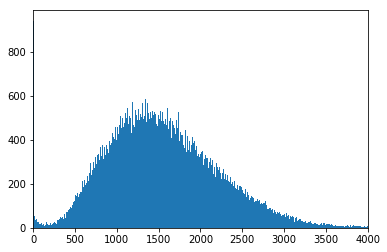

In [505]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(g, bins=1000)
plt.xlim(0,4000)
